In [3]:
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt


db = mysql.connector.connect(host="localhost",
                             username="root",
                             password="devank@11",
                             database="ecommerce")

#now we will activate the cursor
cur=db.cursor()

# List all unique cities where customers are located.

In [11]:
query="""select distinct customer_city from customers"""


cur.execute(query)


data=cur.fetchall()

data

df=pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [5]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""


cur.execute(query)


data=cur.fetchall()

data[0][0]

225505

# Find the total sales per category.

In [6]:
query="""select products.product_category category  , round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id=order_items.order_id
group by category"""


cur.execute(query)


data=cur.fetchall()

data

df=pd.DataFrame(data)
df

,0,1
0,perfumery,6.334233e+07
1,Furniture Decoration,1.787720e+08
2,telephony,6.086026e+07
3,Fashion Bags and Accessories,2.726978e+07
4,bed table bath,2.140692e+08
...,...,...
69,cds music dvds,1.499288e+05
70,La Cuisine,3.641912e+05
71,Fashion Children's Clothing,9.820875e+04
72,PC Gamer,2.718038e+05


# Calculate the percentage of orders that were paid in installments.

In [9]:
query="""select sum((case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments """


cur.execute(query)


data=cur.fetchall()

data


[(Decimal('99.9981'),)]

# Count the number of customers from each state. 


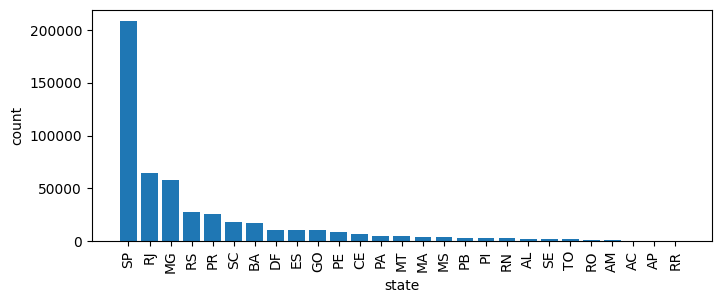

In [25]:
query="""select customer_state,count(customer_id) from customers group by customer_state """


cur.execute(query)


data=cur.fetchall()

df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)

plt.figure(figsize=(8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("state")
plt.ylabel("count")
plt.show()


# Calculate the number of orders per month in 2018.

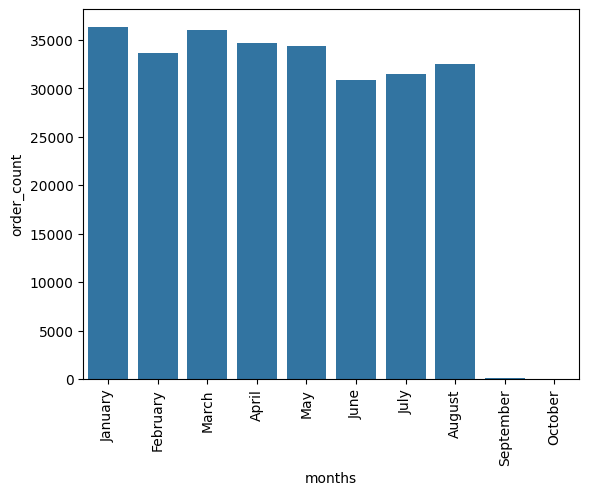

In [23]:
query="""select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018 
group by months"""


cur.execute(query)


data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
o=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"] 



sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o)
plt.xticks(rotation=90)
plt.show()

# Find the average number of products per order, grouped by customer city

In [28]:
query="""with count_per_order as (select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city"""

cur.execute(query)


data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_city","average_orders"])
df.head(10)               

,customer_city,average_orders
0,sao jose dos campos,28.46
1,indaial,27.88
2,treze tilias,31.82
3,sao paulo,28.91
4,rio de janeiro,28.67
5,mario campos,33.33
6,guariba,25.00
7,cuiaba,29.94
8,franca,31.29
9,tocos,25.00


# Calculate the percentage of total revenue contributed by each product category.

In [31]:
query="""select products.product_category category  , round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id=order_items.order_id
group by category"""


cur.execute(query)


data=cur.fetchall()

data

[('perfumery', 79.13),
 ('Furniture Decoration', 223.34),
 ('telephony', 76.03),
 ('Fashion Bags and Accessories', 34.07),
 ('bed table bath', 267.44),
 ('automotive', 133.1),
 ('computer accessories', 247.57),
 ('housewares', 170.96),
 ('babies', 84.3),
 ('toys', 96.67),
 ('Furniture office', 101.01),
 ('Cool Stuff', 121.76),
 ('HEALTH BEAUTY', 258.82),
 ('pet Shop', 48.61),
 ('General Interest Books', 10.1),
 ('stationary store', 49.57),
 ('Watches present', 223.19),
 ('PCs', 43.59),
 ('climatization', 14.24),
 ('Construction Tools Construction', 37.71),
 ('sport leisure', 217.4),
 ('Bags Accessories', 29.23),
 ('electronics', 40.58),
 ('Casa Construcao', 21.34),
 ('Games consoles', 30.53),
 ('home appliances', 14.92),
 ('Garden tools', 130.91),
 ('Agro Industria e Comercio', 18.54),
 (None, 39.48),
 ('audio', 9.42),
 ('technical books', 3.89),
 ('Construction Tools Garden', 6.62),
 ('Market Place', 7.08),
 ('musical instruments', 36.4),
 ('Drink foods', 4.26),
 ('SIGNALIZATION AND S

# Identify the correlation between product price and the number of times a product has been purchased.

In [38]:
import numpy as np
query="""select products.product_category,count(order_items.product_id),round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""


cur.execute(query)


data=cur.fetchall()


df=pd.DataFrame(data,columns=["Category","order_count","price"])

arr1=df["order_count"]
arr2=df["price"]
np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.


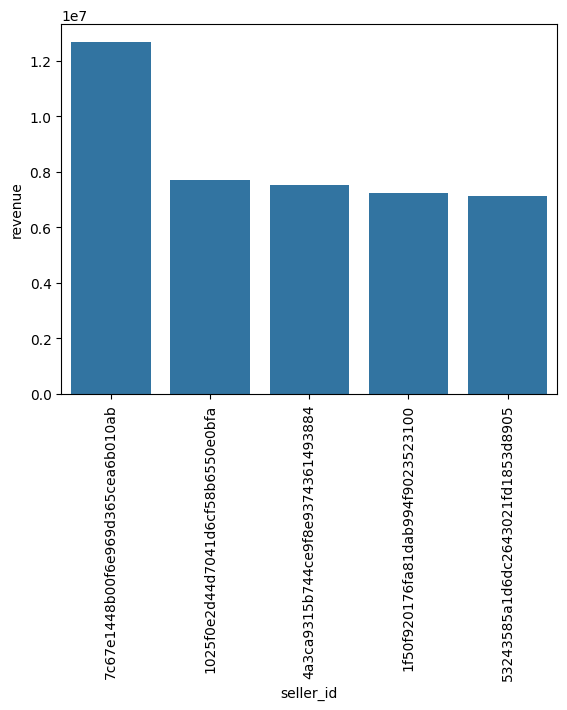

In [42]:
query="""select *,dense_rank()  over(order by revenue desc) as rn from 
(select order_items.seller_id,sum(payments.payment_value) revenue from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a """


cur.execute(query)


data=cur.fetchall()
df=pd.DataFrame(data,columns = ["seller_id","revenue","rank"])
df=df.head()
sns.barplot(x="seller_id",y="revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [45]:
#this is a important question
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment from payments join orders
on payments.order_id=orders.order_id) as a"""

cur.execute(query)


data=cur.fetchall()
data

# Calculate the cumulative sales per month for each year.

In [56]:
query="""select years , months, payment, round(sum(payment) over(order by years,months),2) cum_sale from(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment   from orders join payments
on orders.order_id=payments.order_id
group by years,months order by years,months) as b"""

cur.execute(query)


data=cur.fetchall()
df=pd.DataFrame(data)
df


,0,1,2,3
0,2016,December,490.50,4.905000e+02
1,2016,October,1477262.00,1.477752e+06
2,2016,September,6306.00,1.484058e+06
3,2017,April,10444700.74,1.192876e+07
4,2017,August,16859908.00,2.878867e+07
5,2017,December,21960037.00,5.074870e+07
6,2017,February,7297700.24,5.804640e+07
7,2017,January,3462201.00,6.150861e+07
8,2017,July,14809572.99,7.631818e+07
9,2017,June,12781909.51,8.910009e+07


 # Calculate the year-over-year growth rate of total sales.

In [57]:
query="""with a as (select year(orders.order_purchase_timestamp) as years,
sum(payments.payment_value) as payment from orders join payments
on orders.order_id=payments.order_id
group by years order by years)

select years, ((payment - lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 from a"""


cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0,1
0,2016,NaN
1,2017,12112.703760
2,2018,20.000924


 # Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [59]:
query="""with a as (select customers.customer_id,min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp > first_order
and  orders.order_purchase_timestamp <
date_add(first_order, interval 6 month)
group by a.customer_id)
select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b 
on a.customer_id=b.customer_id"""

cur.execute(query)


data=cur.fetchall()
df=pd.DataFrame(data)
df



,0
0,None


# Identify the top 3 customers who spent the most money in each year.

In [63]:
query="""select years,customer_id,payment,d_rank from(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value)  desc) d_rank
from orders join payments
on payments.order_id=orders.order_id
group by  year(orders.order_purchase_timestamp) ,
orders.customer_id) as a
where d_rank<3"""

cur.execute(query)


data=cur.fetchall()
df=pd.DataFrame(data)
df


,0,1,2,3
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,35588.751221,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,35018.499756,2
2,2017,1617b1357756262bfa56ab541c47bc16,341602.001953,1
3,2017,c6e2731c5b391845f6800c97401a43a9,173232.751465,2
4,2018,ec5b2ba62e574342386871631fafd3fc,181871.997070,1
5,2018,f48d464a0baaea338cb25f816991ab1f,173055.249023,2
